# Bank Customer Churn Prediction. Exploring the Impact of Class Imbalance and Various Methods of Solving Class Imbalance Issue.

The purpose of this study is to make a machine learning model for the most accurate prediction of bank customer churn based on known historical data on past customer behavior.

We will start the study by exploring and preparing the data. First, we will examine the data for the correctness of the data, their types, the presence of missing values and duplicates. Then, if necessary, carry out the appropriate data transformations. Examine the distribution of classes in the target feature.

If a class imbalance is found, the impact of the imbalance should be examined. To do this, it will be necessary to build models without taking into account imbalances and using imbalance neutralization methods, and then compare the results. As a target metric, we will use F1-score, as well as AUC-ROC-Score.

Based on the results of comparing the performance of models, we will choose the best of them and test it on a test split.

## Data Preparation

### Reading and explorng the data

In [1]:
# Importing all required libraries and modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier

np.random.seed(23)
sns.set(rc={'figure.figsize':(10, 10)}, palette='Set2')
warnings.filterwarnings('ignore')

Fix a random state

In [2]:
RANDOM_STATE = 23

Reading the data into the data variable and display the first 5 lines of the dataset, as well as information about the dataset.

In [3]:
data = pd.read_csv('datasets/Churn.csv')

In [4]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Features**  
RowNumber — data string index  
CustomerId — unique customer identifier  
Surname — surname  
CreditScore — credit score  
Geography — country of residence  
Gender — gender  
Age — age  
Tenure — period of maturation for a customer’s fixed deposit (years)  
Balance — account balance  
NumOfProducts — number of banking products used by the customer  
HasCrCard — customer has a credit card  
IsActiveMember — customer’s activeness  
EstimatedSalary — estimated salary  

**Target**  
Exited — сustomer has left

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


The dataset has 10,000 rows with information in 14 columns. Data types are displayed correctly. The 'Tenure' column is missing information in 909 rows, which is just over 9% of the dataset. The dataset has two columns with categorical data types as strings: 'Gender' and 'Geography', which will need to be converted.

In [6]:
# Display the number of empty values in the dataset by columns
data.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

The remaining columns contain data that may be useful in training models, and since there are a lot of missing values ​​in the column (more than 9%), the missing values should be filled in.

Explore information about the values ​​in quantitative variables.

In [7]:
data[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']].describe()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,NumOfProducts
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,100090.239881,1.530200
std,96.653299,10.487806,2.894723,62397.405202,57510.492818,0.581654
min,350.000000,18.000000,0.000000,0.000000,11.580000,1.000000
25%,584.000000,32.000000,2.000000,0.000000,51002.110000,1.000000
50%,652.000000,37.000000,5.000000,97198.540000,100193.915000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,149388.247500,2.000000
max,850.000000,92.000000,10.000000,250898.090000,199992.480000,4.000000


Data in scale variables have widely varying ranges. For some machine learning models, this can reduce their quality, so real data should be scaled.

Explore the number of unique values ​​in the 'Surname' column.

In [8]:
len(data['Surname'].unique())

2932

The amount of unique data is comparable to the size of the entire dataset. There are too many unique values for machine learning. It would be better to remove this data before training the models. Also in the dataset there are columns 'RowNumber', which duplicates the index and 'UserId', which also contains unique values. These three columns should be removed.

Exploring uniqe values in categorical type columns

In [9]:
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

There are only three unique values in Geography column

In [10]:
data['Gender'].unique()

array(['Female', 'Male'], dtype=object)

Categorical data 'Gender' and 'Geography' can be converted using the One Hot Encoding method.

Let's make sure that the categorical variables are represented by only two values, and also look at their relationships.

In [11]:
data['HasCrCard'].value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

In [12]:
data['IsActiveMember'].value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

In [13]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Check the data for duplicates.

In [14]:
data.duplicated().sum()

0

No duplicates in data.

Histograms of feature distribution.

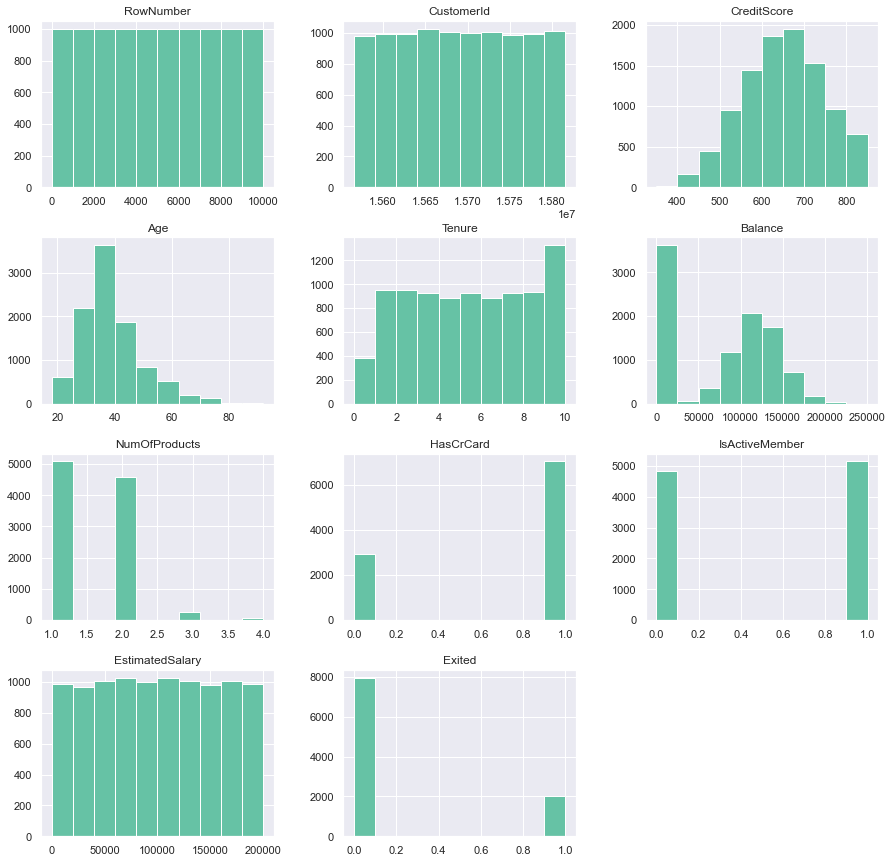

In [15]:
data.hist(figsize=(15, 15));

From the constructed histograms, we can note a large number of zeros in the 'Balance' column, an imbalance in the values ​​in the 'NumOfProducts', 'HasCrCard' and 'Exited' columns.

### Data preparation

#### Removing non-informative features

In [16]:
data = data.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)

#### Coding of categorical variables

Encoding categorical variables using the One Hot Encoding method.

In [17]:
enc = OneHotEncoder(handle_unknown='error', drop='first', sparse=False)
enc.fit(data[['Geography', 'Gender']])  
data[['Geography_spain', 'Geography_germany', 'Gender_male']] = enc.transform(data[['Geography', 'Gender']]).astype(int)

In [18]:
data = data.drop(['Geography', 'Gender'], axis=1)

In [19]:
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_spain,Geography_germany,Gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


The coding of the categorical variables was successful.

#### Filling in the missed values

Let's fill in the missing data using the KNN method, that is, the missing features are filled based on the available features of the nearest neighbors. Neighbors in this case are data that have the closest non-missing features.

In [20]:
imputer = KNNImputer(n_neighbors=3, weights='uniform')
data[:] = imputer.fit_transform(data)

In [21]:
# Round values
data['Tenure'] = data['Tenure'].round()

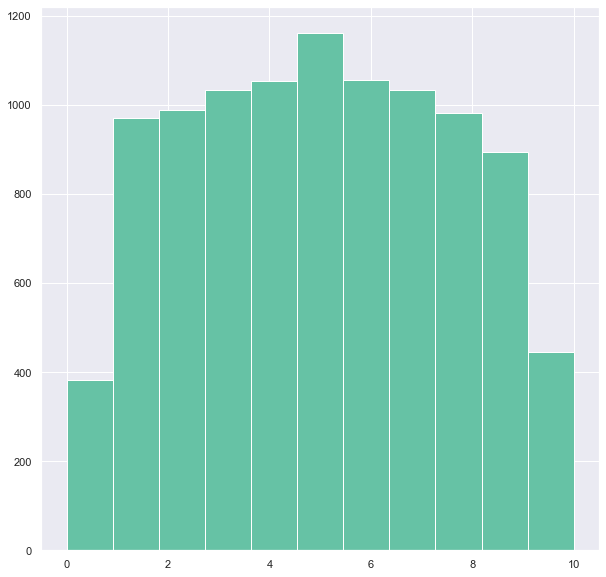

In [22]:
data['Tenure'].hist(bins=11);

All values filled in.

#### Spliting the data

Let's divide the data into three splits - training, validation and test in the ratio 3:1:1. Applying stratification to preserve the ratio of classes.

In [23]:
train, valid = train_test_split(data, test_size=0.4, random_state=RANDOM_STATE, stratify=data['Exited'])
valid, test = train_test_split(valid, test_size=0.5, random_state=RANDOM_STATE, stratify=valid['Exited'])

In [24]:
# Split check
len(train), len(valid), len(test)

(6000, 2000, 2000)

#### Feature Scalling

Before scaling, let's select those data columns that store numerical data.

In [25]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

We will produce all real data to a single scale in the range from 0 to 1. And also save the untransformed data in different variables.

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train[numeric])
train[numeric] = scaler.transform(train[numeric])
valid[numeric] = scaler.transform(valid[numeric])
test[numeric] = scaler.transform(test[numeric])

#### Dividing the data into features and target.

In [27]:
X_train = train.drop('Exited', axis=1)
y_train = train['Exited']
X_valid = valid.drop('Exited', axis=1)
y_valid = valid['Exited']
X_test = test.drop('Exited', axis=1)
y_test = test['Exited']

### Summary

The dataset has 10,000 rows with information in 14 columns. In one column ('Tenure') missing values were found in the amount of 909 rows (which is just over 9% of the dataset). Gaps were filled using the KNN filling method. Further, the encoding of data with categorical data types ('Gender' and 'Geography') was performed using the One-Hot-Encoding method. Part of the data was removed, in particular the 'RowNumber' columns, which duplicated the dataset indexes and 'UserId', which also contains unique customer values, as well as the 'Surname' column with customers' last names. Data with quantitative variables were scaled. Then the data was divided into three splits and the target features were identified for each of the samples.

## Problem research

### Class balance research

Let's plot a class distribution histogram for the values from the 'Exited' column.

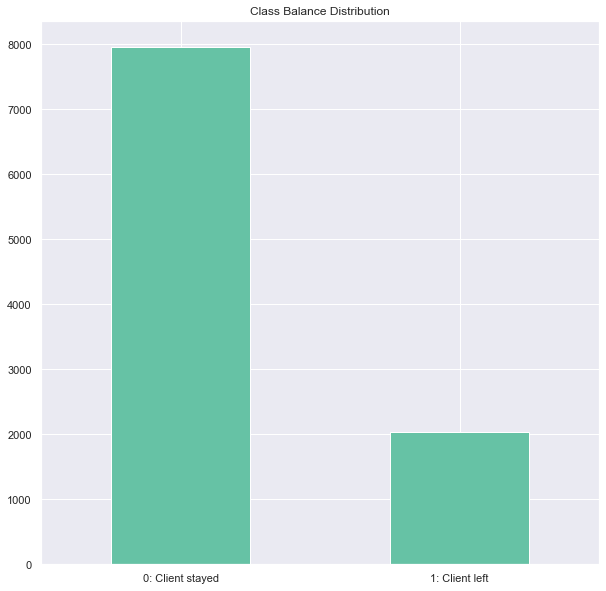

In [28]:
target_classes = data['Exited'].value_counts()
target_classes.plot(kind='bar', title='Class Balance Distribution', grid=True)

plt.xticks(ticks=target_classes.index, labels=['0: Client stayed', '1: Client left'], rotation=0)
plt.show()

In [29]:
data['Exited'].value_counts()

0.0    7963
1.0    2037
Name: Exited, dtype: int64

Target feature classes are unbalanced. There is a clear imbalance of classes in favor of the negative class. The ratio of classes 0 and 1 has a ratio of approximately 4 to 1. 

### Drawing up a summary table of research results

In [30]:
model_results = pd.DataFrame(index=['LogisticRegression',
                                    'SVC',
                                    'DecisionTreeClassifier',
                                    'RandomForestClassifier',
                                    'GradientBoostingClassifier'], 
                             columns=['Baseline', 
                                      'Built-in', 
                                      'Upscale',
                                      'Upscale + Downscale',
                                      'Threshold Tuning',
                                      'Hyperparameters Tuning',
                                      'Threshold + Hyperparameters Tuning'])

In [31]:
def model_test(estimator, features_train, target_train, features_valid, target_valid, params, results_df, research_step):
    model = estimator(**params)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    f1 = round(f1_score(target_valid, predictions), 2)
    roc_auc = round(roc_auc_score(target_valid, predictions), 2)
    results = f'F1: {f1} ROC-AUC: {roc_auc}'
    print(results)
    results_df.loc[type(model).__name__, research_step] = f1

### Exploring Machine Learning Models Without Considering Class Imbalance

First, let's explore various machine learning models on data with imbalanced classes.

#### Logistic Regression Model

In [32]:
params_lr = {'random_state':RANDOM_STATE}

model_test(LogisticRegression, X_train, y_train, X_valid, y_valid, params_lr, model_results, 'Baseline')

F1: 0.32 ROC-AUC: 0.59


#### Support Vector Model with Polynomial Kernel

In [33]:
params_svc = {'kernel':'poly', 
              'degree':3, 
              'random_state':RANDOM_STATE, 
              'max_iter':10000}

model_test(SVC, X_train, y_train, X_valid, y_valid, params_svc, model_results, 'Baseline')

F1: 0.47 ROC-AUC: 0.66


#### Decision Tree Model

In [34]:
params_dt = {'random_state':RANDOM_STATE}

model_test(DecisionTreeClassifier, X_train, y_train, X_valid, y_valid, params_dt, model_results, 'Baseline')

F1: 0.51 ROC-AUC: 0.69


#### Random Forest Model

In [35]:
params_rf = {'random_state':RANDOM_STATE}

model_test(RandomForestClassifier, X_train, y_train, X_valid, y_valid, params_rf, model_results, 'Baseline')

F1: 0.59 ROC-AUC: 0.72


#### Gradient Boosting Model

In [36]:
params_gb = {'random_state':RANDOM_STATE}

model_test(GradientBoostingClassifier, X_train, y_train, X_valid, y_valid, params_gb, model_results, 'Baseline')

F1: 0.61 ROC-AUC: 0.73


####  Summary

The logistic regression model showed the worst results, the random forest and gradient boosting models showed the best results, exceeding the minimum threshold of the target metric F1-Scroe 0.59. The ROC-AUC metric, as can be seen from the results, has a strong relationship with the F1 metric.

## Imbalance Issue Solving

Class imbalance in the target feature can degrade the quality of model predictions. Let's try different ways to deal with imbalance.

### Adjusting Class Balance in Hyperparameters

#### Logistic Regression Model

In [37]:
params_lr_bal = {'random_state':RANDOM_STATE, 
                 'class_weight':'balanced'}

model_test(LogisticRegression, X_train, y_train, X_valid, y_valid, params_lr_bal, model_results, 'Built-in')

F1: 0.48 ROC-AUC: 0.69


The logistic regression model showed a significant improvement in the target metric with balanced classes.

#### Support Vector Classificator with polynomial kernel

In [38]:
params_svc_bal = {'kernel':'poly', 
                  'degree':3,
                  'random_state':RANDOM_STATE,
                  'max_iter':10000,
                  'class_weight':'balanced'}

model_test(SVC, X_train, y_train, X_valid, y_valid, params_svc_bal, model_results, 'Built-in')

F1: 0.57 ROC-AUC: 0.76


The SVC model also showed an improvement in the target metric after class balancing, exceeding the minimum threshold value of the F1-Score metric. The AUC-ROC metric also improved.

#### Decision Tree Model

In [39]:
params_dt_bal = {'random_state':RANDOM_STATE, 
                 'class_weight':'balanced'}

model_test(DecisionTreeClassifier, X_train, y_train, X_valid, y_valid, params_dt_bal, model_results, 'Built-in')

F1: 0.49 ROC-AUC: 0.68


The built-in class balancing had very little impact on the decision tree model. The minimum threshold for the target metric value has not been exceeded. We can conclude that for the decision tree model, the 4:1 class imbalance does not significantly affect the prediction results. The F1-Score and ROC-AUC metrics remained at approximately the same levels.

#### Random Forest Model

In [40]:
params_rf_bal = {'random_state':RANDOM_STATE, 
                 'class_weight':'balanced'}

model_test(RandomForestClassifier, X_train, y_train, X_valid, y_valid, params_rf_bal, model_results, 'Built-in')

F1: 0.56 ROC-AUC: 0.7


The random forest model showed some decrease in the target metric when the built-in class balancing was activated. We can conclude that for a random forest model, class imbalance does not have a critical impact on the result of predictions.

#### Gradient Boosting Model

In the gradient boosting model, there is no hyperparameter that balances the classes, because in this model, the presence of imbalance is not so significant.

####  Conclusion

For the logistic regression model and the support vector model, the built-in class balancing methods significantly improve the quality of the models. For other methods, the built-in balancing methods do not have a significant impact on our data.

### Leveling the ratio of classes by the method of increasing the data

In the case of classes imbalance in data with a small amount of data, as in our case, we can equalize the ratio of classes in the target feature using the upsampling method.

In [41]:
# At first, we'll divide the training dataset depending on the class of the target feature.
train_pos = train[train['Exited']==1]
len(train_pos)

1222

In [42]:
train_neg = train[train['Exited']==0]
len(train_neg)

4778

In [43]:
# After increasing the amount of data with a positive class and write it down to a new variable.
train_pos_upsampled = resample(train_pos, random_state=RANDOM_STATE, n_samples=len(train_neg), replace=True)

In [44]:
# Then merge the data with targets 0 and 1.
train_upsampled = pd.concat([train_pos_upsampled, train_neg])

In [45]:
# Check the correctness
len(train_upsampled)

9556

In [46]:
# Extracting the target feature and writing down the data into new variables
X_train_us = train_upsampled.drop('Exited', axis=1)
y_train_us = train_upsampled['Exited']

**Models Check**

#### Logistic Regression Model

In [47]:
model_test(LogisticRegression, X_train_us, y_train_us, X_valid, y_valid, params_lr, model_results, 'Upscale')

F1: 0.48 ROC-AUC: 0.69


The values of the target metrics are almost the same as when using the built-in balancing method.

#### SVC Model with Polynomial Kernel

In [48]:
model_test(SVC, X_train_us, y_train_us, X_valid, y_valid, params_svc, model_results, 'Upscale')

F1: 0.56 ROC-AUC: 0.76


The values of target metrics after upsampling are little bit worse than when using the built-in class balancing method.

#### Decision Tree Model

In [49]:
model_test(DecisionTreeClassifier, X_train_us, y_train_us, X_valid, y_valid, params_dt, model_results, 'Upscale')

F1: 0.48 ROC-AUC: 0.67


The values of the target metrics for the decision tree are the same as when using the built-in balancing method.

#### Random Forest Method

In [50]:
model_test(RandomForestClassifier, X_train_us, y_train_us, X_valid, y_valid, params_rf, model_results, 'Upscale')

F1: 0.6 ROC-AUC: 0.74


The random forest model performed higher target metrics when trained on upsampled data.

#### Gradient Boosting Model

In [51]:
model_test(GradientBoostingClassifier, X_train_us, y_train_us, X_valid, y_valid, params_gb, model_results, 'Upscale')

F1: 0.61 ROC-AUC: 0.78


The Gradient Boosting Model also performs better results when trained on upsampled data.

#### Conclusion

For most machine learning models, class levering by upsampling performs results almost alike built-in class balancing methods. Upsampling gives the best increase in quality in ensembles based models.

### Combined imbalance levering method (increasing + decreasing the data)

The downsampling method is usually used on large data (100,000 rows or more), so it is not applicable on our dataset. Probably it will not provide a significant improvement in model training. Therefore, we'll try to apply a combined method: we will perform downsampling for data with a dominant class in the target feature, and upsampling for data with a rare class.

In [52]:
# Bringing the size of the samples for each of the classes to the arithmetic mean of the classes.
samples_num = int((len(train_pos) + len(train_neg)) / 2) 
samples_num

3000

In [53]:
# Increasing the amount of data with a positive class and write it down to a new variable.
train_pos_us = resample(train_pos, random_state=RANDOM_STATE, n_samples=samples_num, replace=True)

In [54]:
# For the negative classe doing the opposite
train_neg_ds = resample(train_neg, random_state=RANDOM_STATE, n_samples=samples_num, replace=True)

In [55]:
# Merging the data
train_cs = pd.concat([train_pos_us, train_neg_ds])

In [56]:
# Data size check
train_cs.value_counts('Exited')

Exited
0.0    3000
1.0    3000
dtype: int64

In [57]:
# Extracting the target feature
X_train_cs = train_cs.drop('Exited', axis=1)
y_train_cs = train_cs['Exited']

#### Logistic Regression Model

In [58]:
model_test(LogisticRegression, X_train_cs, y_train_cs, X_valid, y_valid, params_lr, model_results, 'Upscale + Downscale')

F1: 0.48 ROC-AUC: 0.69


Target metrics after combined resampling are similar to the results of the upsampling method.

#### SVC Model with Polynomial Kernel


In [59]:
model_test(SVC, X_train_cs, y_train_cs, X_valid, y_valid, params_svc, model_results, 'Upscale + Downscale')

F1: 0.56 ROC-AUC: 0.75


Target metrics after combined resampling are similar to the results of the upsampling method.

#### Decision Tree Model

In [60]:
model_test(DecisionTreeClassifier, X_train_cs, y_train_cs, X_valid, y_valid, params_dt, model_results, 'Upscale + Downscale')

F1: 0.51 ROC-AUC: 0.71


The target metrics of combined resampling for the decision tree model are slightly lower than the results of the upsampling method.

#### Random Forest Model

In [61]:
model_test(RandomForestClassifier, X_train_cs, y_train_cs, X_valid, y_valid, params_rf, model_results, 'Upscale + Downscale')

F1: 0.63 ROC-AUC: 0.78


The target metrics of combined resampling are similar to the results of the upsampling method.

#### Gradient Boosting Model

In [62]:
model_test(GradientBoostingClassifier, X_train_cs, y_train_cs, X_valid, y_valid, params_gb, model_results, 'Upscale + Downscale')

F1: 0.6 ROC-AUC: 0.78


The target metrics of combined resampling are similar to the results of the upsampling method.

####  Summary

In general, for most ML methods, balancing classes by combined resampling method shows results slightly worse than upsampling.

### Tuning of the Optimal Classification Threshold

Let's try to lower the threshold value at which the class is assigned either the value 1 or 0. By default, the threshold value is 0.5, that is, if the predicted probability of the class is greater than it, the value 1 is returned, if less - 0. We will iterate over the threshold values from 0 to 1 and let's see how changing the threshold will affect the values of the F1-score metric on different models.

In [63]:
def threshold_search(estimator, features_train, target_train, features_valid, target_valid, params, results_df, research_step):
    model = estimator(**params)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    # Threshold values that we will iterate over in the loop
    thresholds = np.arange(0.0, 0.5, 0.001)
    # Create array to write the values of f-score and roc-auc
    fscore = np.zeros(shape=(len(thresholds)))
    ra_score = np.zeros(shape=(len(thresholds)))

    # Probabilities of class 1 on validation sample data
    prob_valid = model.predict_proba(features_valid)[:, 1]

    for index, elem in enumerate(thresholds):
        # Compare the probability value with the threshold value, translate into binary
        predictions_prob = (prob_valid > elem).astype('int')
        # Calculating metrics
        fscore[index] = f1_score(target_valid, predictions_prob)
        ra_score[index] = roc_auc_score(target_valid, predictions_prob)

    # Index of the optimal threshold value with the maximum f-score
    index = np.argmax(fscore)
    threshold_opt = thresholds[index]
    fscore_opt = round(fscore[index], 2)
    ra_score_opt = round(ra_score[index], 2)
    print(f'F1 Score: {fscore_opt}, ROC-AUC Score: {ra_score_opt}, Best Threshold: {threshold_opt}')
    results_df.loc[type(model).__name__, research_step] = fscore_opt
    
    return threshold_opt

#### Logistic Regression Model

In [64]:
threshold_search(LogisticRegression, X_train, y_train, X_valid, y_valid, params_lr, model_results, 'Threshold Tuning')

F1 Score: 0.49, ROC-AUC Score: 0.7, Best Threshold: 0.212


0.212

#### SVC Model with Polynomial Kernel

In [65]:
params_svc['probability'] = True

In [66]:
threshold_search(SVC, X_train, y_train, X_valid, y_valid, params_svc, model_results, 'Threshold Tuning')

F1 Score: 0.58, ROC-AUC Score: 0.74, Best Threshold: 0.224


0.224

#### Decision Tree Model

In [67]:
threshold_search(DecisionTreeClassifier, X_train, y_train, X_valid, y_valid, params_dt, model_results, 'Threshold Tuning')

F1 Score: 0.51, ROC-AUC Score: 0.69, Best Threshold: 0.0


0.0

#### Random Forest Model

In [68]:
threshold_search(RandomForestClassifier, X_train, y_train, X_valid, y_valid, params_rf, model_results, 'Threshold Tuning')

F1 Score: 0.64, ROC-AUC Score: 0.76, Best Threshold: 0.39


0.39

#### Gradient Boosting Model

In [69]:
threshold_search(GradientBoostingClassifier, X_train, y_train, X_valid, y_valid, params_gb, model_results, 'Threshold Tuning')

F1 Score: 0.63, ROC-AUC Score: 0.78, Best Threshold: 0.271


0.271

####  Summary

In general, for most machine learning methods, class balancing by selecting the optimal classification threshold on the validation set shows results slightly higher than other methods.

### Hyperparameter tuning

To improve the quality of model predictions, let's try to tune hyperparameters for our models.

Since further we will use cross-validation, we will combine the validation and training sets.

In [70]:
X_comb = pd.concat([X_train, X_valid])
y_comb = pd.concat([y_train, y_valid])

In [71]:
def random_search(estimator, features, target, params, random_state, results_df, research_step):
    """
    Function for hyper paramters tuning
    """
    rss = RandomizedSearchCV(estimator(), 
                             param_distributions=params,
                             scoring='f1', 
                             cv=5, random_state=random_state, 
                             n_iter=30, 
                             n_jobs=-1)
    
    rss.fit(features, target)
    
    best_score = round(rss.best_score_, 2)
    best_params = rss.best_params_
    best_params['random_state'] = RANDOM_STATE
    
    print(f'Best score: {best_score}')
    results_df.loc[type(rss.best_estimator_).__name__, research_step] = best_score
        
    return best_params

#### Logistic Regression

In [72]:
params_grid_lr = {'penalty': ['l1', 'l2', 'elasticnet'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [73]:
lr_best_params_cv = random_search(LogisticRegression, X_comb, y_comb, params_grid_lr, RANDOM_STATE, model_results, 'Hyperparameters Tuning')

Best score: 0.31


In [74]:
lr_best_params_cv

{'penalty': 'l2', 'C': 100, 'random_state': 23}

#### SVC

In [75]:
params_grid_svc = {'C': (0.001, 0.01, 0.1, 1, 10, 100, 1000),
                   'degree': range(1, 5, 1)}

In [76]:
svc_best_params_cv = random_search(SVC, X_comb, y_comb, params_grid_svc, RANDOM_STATE, model_results, 'Hyperparameters Tuning')

Best score: 0.54


In [77]:
svc_best_params_cv['probability'] = True

#### Decision Tree

In [78]:
params_grid_dt = {'criterion': ('gini', 'entropy'),
                  'max_depth': range(1, 21, 2),
                  'min_samples_leaf': range(1, 8),
                  'min_samples_split': range(2, 20, 1)}

In [79]:
dt_best_params_cv = random_search(DecisionTreeClassifier, X_comb, y_comb, params_grid_dt, RANDOM_STATE, model_results, 'Hyperparameters Tuning')

Best score: 0.55


In [80]:
dt_best_params_cv

{'min_samples_split': 6,
 'min_samples_leaf': 6,
 'max_depth': 7,
 'criterion': 'gini',
 'random_state': 23}

#### Random Forest

In [81]:
params_grid_rf = {'criterion': ('gini', 'entropy'),
                  'n_estimators': range(25, 251, 25),
                  'max_depth': range(1,21, 2),
                  'min_samples_leaf': range(1,8),
                  'min_samples_split': range(2,10,2)}

In [82]:
rf_best_params_cv = random_search(RandomForestClassifier, X_comb, y_comb, params_grid_rf, RANDOM_STATE, model_results, 'Hyperparameters Tuning')

Best score: 0.57


In [83]:
rf_best_params_cv

{'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 17,
 'criterion': 'gini',
 'random_state': 23}

#### Gradient Boosting

In [84]:
params_grid_gb = {'learning_rate': np.arange(0.01, 0.11, 0.01),
                  'n_estimators': range(10, 201, 25),
                  'max_depth': range(1,21, 2),
                  'min_samples_leaf': range(1,8),
                  'min_samples_split': range(2,10,2)}

In [85]:
gb_best_params_cv = random_search(GradientBoostingClassifier, X_comb, y_comb, params_grid_gb, RANDOM_STATE, model_results, 'Hyperparameters Tuning')

Best score: 0.58


In [86]:
gb_best_params_cv

{'n_estimators': 135,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 5,
 'learning_rate': 0.060000000000000005,
 'random_state': 23}

#### Summary

By the hyperparameters tuning, we managed to slightly increase metrics.

### Hyperparameter tuning + Threshold optimization

Now let's try to tune hyperparameters on models with optimized classification threshold.

#### Logistic Regression

In [87]:
threshold_lr = threshold_search(LogisticRegression, X_train, y_train, X_valid, y_valid, lr_best_params_cv, model_results, 'Threshold + Hyperparameters Tuning')

F1 Score: 0.49, ROC-AUC Score: 0.7, Best Threshold: 0.212


#### SVC

In [88]:
threshold_svc = threshold_search(SVC, X_train, y_train, X_valid, y_valid, svc_best_params_cv, model_results, 'Threshold + Hyperparameters Tuning')

F1 Score: 0.55, ROC-AUC Score: 0.72, Best Threshold: 0.265


#### Decision Tree

In [89]:
threshold_dt = threshold_search(DecisionTreeClassifier, X_train, y_train, X_valid, y_valid, dt_best_params_cv, model_results, 'Threshold + Hyperparameters Tuning')

F1 Score: 0.6, ROC-AUC Score: 0.74, Best Threshold: 0.364


#### Random Forest

In [90]:
threshold_rf = threshold_search(RandomForestClassifier, X_train, y_train, X_valid, y_valid, rf_best_params_cv, model_results, 'Threshold + Hyperparameters Tuning')

F1 Score: 0.63, ROC-AUC Score: 0.78, Best Threshold: 0.315


#### Gradient Boosting

In [91]:
threshold_gb = threshold_search(GradientBoostingClassifier, X_train, y_train, X_valid, y_valid, gb_best_params_cv, model_results, 'Threshold + Hyperparameters Tuning')

F1 Score: 0.63, ROC-AUC Score: 0.76, Best Threshold: 0.368


### Summarized Results

In [92]:
model_results

,Baseline,Built-in,Upscale,Upscale + Downscale,Threshold Tuning,Hyperparameters Tuning,Threshold + Hyperparameters Tuning
LogisticRegression,0.32,0.48,0.48,0.48,0.49,0.31,0.49
SVC,0.47,0.57,0.56,0.56,0.58,0.54,0.55
DecisionTreeClassifier,0.51,0.49,0.48,0.51,0.51,0.55,0.6
RandomForestClassifier,0.59,0.56,0.6,0.63,0.64,0.57,0.63
GradientBoostingClassifier,0.61,NaN,0.61,0.6,0.63,0.58,0.63


###  Conclusion

The best metrics for ML models with class imbalance were achieved using classification threshold selection methods.
  * For logistic regression, the F1 value of the measure went up from 0.32 to 0.49
  * Support Vector Machine from 0.49 to 0.58
  * Decision tree metric is left the same 0.51
  * Random forest from 0.59 to 0.64
  * Gradient boosting from 0.61 to 0.63

## Models Test

Let's check the quality of predictions of the best models on the test split.

In [93]:
def roc_curve_plot(y_test, prob_test):
    """
    Function for roc-curve plotting
    """
    fpr, tpr, threshold = roc_curve(y_test, prob_test)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC-curve', fontsize=20)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.show()

### Random Forest Model

In [94]:
best_model_rf = RandomForestClassifier(**rf_best_params_cv).fit(X_comb, y_comb)

In [95]:
prob_test_rf = best_model_rf.predict_proba(X_test)[:, 1]
predictions_prob_rf = (prob_test_rf > threshold_rf).astype('int')
f'F1 Score: {f1_score(y_test, predictions_prob_rf)}, ROC-AUC Score: {roc_auc_score(y_test, predictions_prob_rf)}, Best Threshold: {threshold_rf}'

'F1 Score: 0.6340326340326341, ROC-AUC Score: 0.7774288107202679, Best Threshold: 0.315'

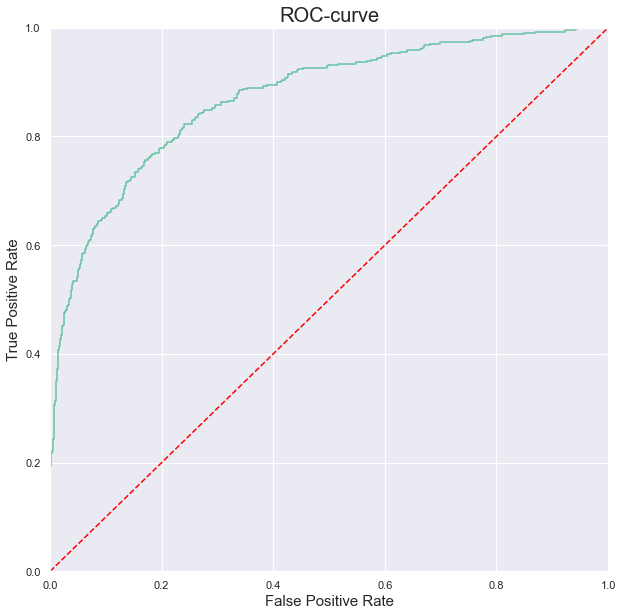

In [96]:
roc_curve_plot(y_test, prob_test_rf)

### Gradient Boosting Model

In [97]:
best_model_gb = GradientBoostingClassifier(**gb_best_params_cv).fit(X_comb, y_comb)

In [98]:
prob_test_gb = best_model_gb.predict_proba(X_test)[:, 1]
predictions_prob_gb = (prob_test_gb > threshold_gb).astype('int')
f'F1 Score: {f1_score(y_test, predictions_prob_gb)}, ROC-AUC Score: {roc_auc_score(y_test, predictions_prob_gb)}, Best Threshold: {threshold_gb}'

'F1 Score: 0.6299615877080665, ROC-AUC Score: 0.7615836535619273, Best Threshold: 0.368'

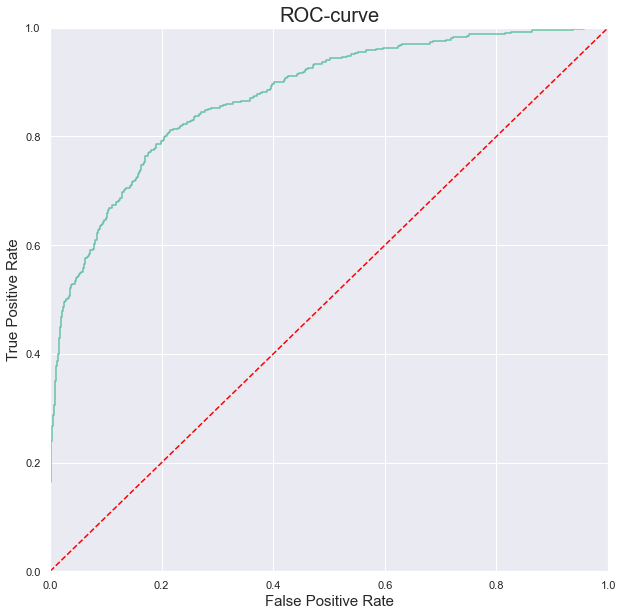

In [99]:
roc_curve_plot(y_test, prob_test_gb)

### Conclusion

Based on the testing results, we can conclude that both models passed the test preformed the F1-Score metric above 0.59. The results of the ROC-AUC metric are approximately 0.76 and 0.77.

##  Summary

During the exploring of the dataset, the following problems and features were identified:
  * The dataset has 10,000 rows with information in 14 columns.
  * In one of the columns ('Tenure') missing values were found in the amount of 909 rows (which is just over 9% of all the data). Missings were filled in using the KNN filling method.
  * Categorical variables were found as string data in two columns (columns 'Gender' and 'Geography'). This data was encoded using the One-Hot-Encoding method.
  * Some data had no practical value for ML models, in particular the 'RowNumber' columns, which duplicated the dataset indexes and 'UserId', which also contains unique customer values, as well as the 'Surname' column with customers' last names. The data has been deleted.
  * Data with quantitative variables had different scales. Data were scaled to the same scale.

Further, in the course of preparation, the data were divided into three splits, from which the target features were extracted for each of the splits.

During the study, it turned out that the classes of the target feature are unbalanced. The classes 0 and 1 has a ratio of approximately 4 to 1.

Initially, the study of ML models was carried out without taking into account the imbalance. The logistic regression model showed the worst results, the random forest and gradient boosting models showed the best results, exceeding the minimum threshold of the target metric F1-Scroe 0.59. The ROC-AUC metric reached 0.73.

Next, four ways to deal with class imbalance were explored:
  * Built-in model balancing hyperparameters
  * Balancing by increasing the training sample
  * Balancing by the method of combined resampling of the training set
  * Balancing by the method of selecting the optimal classification threshold

Then hyperparameters were tuned for each models.

Based on the testing results, we can conclude that both models passed the test preformed the F1-Score metric above 0.59. The results of the ROC-AUC metric are approximately 0.76 and 0.77.

Finally we can conclude that the models meet the targets, the F1 value of the measure is reached, the models can be used to predict customer churn.